# Apache Flume with Checkpoint


We will configure the channel to be a file and, in addition, we will also configure some interesting parameters that will help us when the data input is very large and we want to control the size of the created files, or their closing time. In addition, when using a file as a channel, we can also create a control point that, in case the agent crashes, allows us to recover the point where the transfer was. This is important for a robust and fail-safe system.


## Create folders and download dataset
We will use the dataset of the Argentinian government.

- First, we will create a folder named "flume" in `/media/notebooks/` to store all our work with Flume.
- Inside the "flume" folder, we will create another folder named "configuraciones" to hold all our Flume configuration files.
- We will also create a "data" folder, where we will store the files to be read and later sent via Flume to HDFS.

In [1]:
! pwd

/media/notebooks


In [2]:
# Create folder
! mkdir -p flume

In [3]:
! mkdir -p /media/notebooks/flume/data
! mkdir -p /media/notebooks/flume/data/convocatorias
! mkdir -p /media/notebooks/flume/configuraciones

In [4]:
# Download csv file
! wget https://github.com/Vega90/datasets/raw/main/convocatorias-2020.csv -O \
/media/notebooks/flume/data/convocatorias/convocatorias-2020.csv

--2024-11-10 09:40:22--  https://github.com/Vega90/datasets/raw/main/convocatorias-2020.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Vega90/datasets/main/convocatorias-2020.csv [following]
--2024-11-10 09:40:22--  https://raw.githubusercontent.com/Vega90/datasets/main/convocatorias-2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5675992 (5.4M) [text/plain]
Saving to: ‘/media/notebooks/flume/data/convocatorias/convocatorias-2020.csv’

/media/notebooks/fl 100%[===================>]   5.41M  8.01MB/s    in 0.7s    

2024-11-10 09:40:24 (8.01 MB/s) - ‘/media/notebooks/flume/data/conv

In [5]:
# Move to the folder
import os
os.chdir("/media/notebooks/flume/configuraciones")
! pwd

/media/notebooks/flume/configuraciones


## Agent Configuration File

The configuration file outlines the data flow, which involves copying the content of files in a specified local path to a temporary HDFS file that Flume will create for us. This setup allows an agent to "listen" to everything that arrives in a folder and establish a data flow from that folder to HDFS. Here’s the configuration breakdown:

- **General Agent Configuration**: Here, we name the agent `agenteArg`. In the initial lines, we define the names for the source, channel, and sink, which in this case will be `spoolSource`, `hdfsSink`, and `fileChannel`.

- **Source Configuration**: For the source, we set the type as `spooldir` since we’ll be monitoring a local file directory. We then specify the path for this property.

- **Channel Configuration**: We define the type of channel that will connect our source with the sink. In this case, we use `file`, a file-based channel that will store and process events. We specify the file path to act as the channel and configure a directory for the checkpoint.

- **Sink Configuration**: Since we are writing to HDFS, we set the sink type to `hdfs` and provide the HDFS path where the files will be stored. We then specify the file type as `DataStream` and the data format as `Text`. Unlike the previous example, here we configure a property called `rollSize`, which sets the maximum file size at which the agent will close a file and create a new one.

   - Setting each file size to approximately 4 KB will result in multiple files created by the sink. We also set the `rollInterval` property to close the file after a certain time (150 seconds). Finally, there is a property that closes the file after a specified number of events; we set this to 0, as we are not using a specific event count in this case.

- **Linking Source and Sink to the Channel**: We specify which channel to use for the source and sink. Notably, we use the `channels` property for the source and `channel` for the sink, as a source can write to multiple channels, but a sink can only read from one channel.

In [6]:
%%writefile convocatorias.config

# Configure agent components
agenteArg.sources = spoolSource
agenteArg.sinks = hdfsSink
agenteArg.channels = fileChannel

# Configure the spooldir source type
agenteArg.sources.spoolSource.type = spooldir
agenteArg.sources.spoolSource.spoolDir = /media/notebooks/flume/data/convocatorias

# Configure the channel with checkpoint
agenteArg.channels.fileChannel.type = file
agenteArg.channels.fileChannel.checkpointDir = /media/notebooks/flume/checkpoint/convocatorias
agenteArg.channels.fileChannel.dataDirs = /media/notebooks/flume/channel-data/convocatorias

# Configure sink
agenteArg.sinks.hdfsSink.type = hdfs
agenteArg.sinks.hdfsSink.hdfs.path = hdfs://namenode:9000/flume-arg
agenteArg.sinks.hdfsSink.hdfs.fileType = DataStream
agenteArg.sinks.hdfsSink.hdfs.writeFormat = Text

# Configure the output files in bytes
agenteArg.sinks.hdfsSink.hdfs.rollSize = 4194
# Set the closing time of a file
agenteArg.sinks.hdfsSink.hdfs.rollInterval = 150
# Configure the number of events for closing a file
agenteArg.sinks.hdfsSink.hdfs.rollCount = 0

# Connect the input and output
agenteArg.sources.spoolSource.channels = fileChannel
agenteArg.sinks.hdfsSink.channel = fileChannel

Writing convocatorias.config


Start an Apache Flume agent named `agentArg`, using a specific configuration located in `convocatorias.config`, with the log level in `INFO` displayed in the console.

In [7]:
!flume-ng agent --conf ./conf/ \
 --conf-file /media/notebooks/flume/configuraciones/convocatorias.config \
 --name agenteArg \
 -Dflume.root.logger=INFO,console

Info: Including Hadoop libraries found via (/usr/local/hadoop/bin/hadoop) for HDFS access
Info: Including Hive libraries found via (/usr/local/hive) for Hive access
+ exec /usr/lib/jvm/java-8-openjdk-amd64/bin/java -Xmx20m -Dflume.root.logger=INFO,console -cp './conf/:/usr/local/flume/lib/*:/usr/local/hadoop/etc/hadoop:/usr/local/hadoop/share/hadoop/common/lib/*:/usr/local/hadoop/share/hadoop/common/*:/usr/local/hadoop/share/hadoop/hdfs:/usr/local/hadoop/share/hadoop/hdfs/lib/*:/usr/local/hadoop/share/hadoop/hdfs/*:/usr/local/hadoop/share/hadoop/mapreduce/*:/usr/local/hadoop/share/hadoop/yarn:/usr/local/hadoop/share/hadoop/yarn/lib/*:/usr/local/hadoop/share/hadoop/yarn/*:/usr/local/hive/lib/*' -Djava.library.path=:/usr/local/hadoop/lib/native org.apache.flume.node.Application --conf-file /media/notebooks/flume/configuraciones/convocatorias.config --name agenteArg
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/flume/lib/log4j-slf4j-impl-

We must wait until all the file is read and then stop the execution of the agent (stopping the Jupyter kernel with the stop button or with ctrl+c in the terminal) once we see that the reading of the files has been completed correctly. Since Flume receives the data in streaming, it does not know when to stop listening, therefore, if we do not stop it manually, it will be active indefinitely and we will not be able to execute the following cells.

How to see that the reading of the files has been completed correctly: the word COMPLETED has been added to the end of the file name:

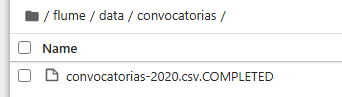

In [8]:
# Check that the file convocatorias has been correctly processed 
! ls /media/notebooks/flume/data/convocatorias

convocatorias-2020.csv.COMPLETED


In [9]:
# See the contents of the checkpoint
! ls /media/notebooks/flume/checkpoint/convocatorias

checkpoint  checkpoint.meta  inflightputs  inflighttakes  queueset


In [10]:
# Contents of the channel data folder
! ls /media/notebooks/flume/channel-data/convocatorias

log-1  log-1.meta


In [11]:
# See the content of the folder where the agent has written
! hdfs dfs -ls /flume-arg

Found 1285 items
-rw-r--r--   3 root supergroup       4714 2024-11-10 09:47 /flume-arg/FlumeData.1731232028012
-rw-r--r--   3 root supergroup       4645 2024-11-10 09:47 /flume-arg/FlumeData.1731232028013
-rw-r--r--   3 root supergroup       4325 2024-11-10 09:47 /flume-arg/FlumeData.1731232028014
-rw-r--r--   3 root supergroup       4605 2024-11-10 09:47 /flume-arg/FlumeData.1731232028015
-rw-r--r--   3 root supergroup       4271 2024-11-10 09:47 /flume-arg/FlumeData.1731232028016
-rw-r--r--   3 root supergroup       4660 2024-11-10 09:47 /flume-arg/FlumeData.1731232028017
-rw-r--r--   3 root supergroup       4213 2024-11-10 09:47 /flume-arg/FlumeData.1731232028018
-rw-r--r--   3 root supergroup       4245 2024-11-10 09:47 /flume-arg/FlumeData.1731232028019
-rw-r--r--   3 root supergroup       4284 2024-11-10 09:47 /flume-arg/FlumeData.1731232028020
-rw-r--r--   3 root supergroup       4288 2024-11-10 09:47 /flume-arg/FlumeData.1731232028021
-rw-r--r--   3 root supergroup       4438 2

In HDFS we see that several FLUME files have been created. These files have been created by the agent reading the content of the file, sending it through the channel, in this case the agent, and finally it has been written by the sink in HDFS. The agent has created multiple files due to partitioning. These files contain the entire contents of the file convocatorias-2020.csv.


We can see the contents of the file and we can see, indeed, how everything has been transmitted successfully. Example of one of the files:


In [1]:
! hdfs dfs -cat /flume-arg/FlumeData.1731232028012

40/51-0159-LPR19,381,381 - Estado Mayor General de La Fuerza Aérea,40,Departamento Contrataciones Córdoba - UOC 40/51,Licitacion Privada,Sin Modalidad,,2019,02/01/2020 08:00:00 a.m.,10/01/2020 10:00:00 a.m.,Única,Nacional,“Adquisición de Elementos de Librería para el HOSPITAL AERONÁUTICO CÓRDOBA,“Adquisición de Elementos de Librería para el HOSPITAL AERONÁUTICO CÓRDOBA,1957142.84,Proceso de Compra
22-0041-CDI19,250,250 - Caja de Retiros Jubilaciones y Pensiones de la Policía Federal,22,22 - Dpto de Compras y Suministros - Caja de Retiros Jubilaciones y Pensiones de la Policía Federal,Contratación Directa,Sin Modalidad,Apartado 1: Compulsa Abreviada Por Monto,2019,02/01/2020 12:00:00 p.m.,13/01/2020 09:00:00 a.m.,Única,Nacional,Servicio de seguridad de información sensible de la página web del Organismo.,Servicio de seguridad de información sensible de la página web del Organismo.,119915.25,Proceso de Compra
40/51-0918-CDI19,381,381 - Estado Mayor General de La Fuerza Aérea,40,Departame

If we access the file explorer through the URL http://localhost:9870/explorer.html, we can see inside the folder example-flume the characteristics of the newly created file. And if we see it in detail we can observe its content:


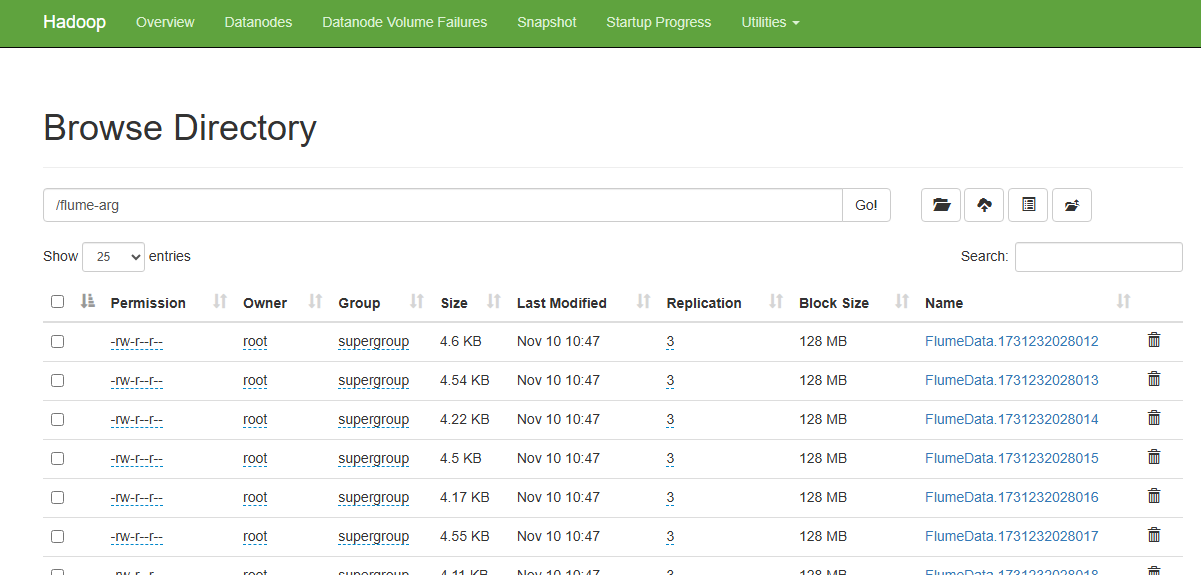